In [9]:
import numpy as np

In [10]:
# first, define our problem size
n = 10
alpha = np.random.random((n, 1))
sigma = np.random.random((n, 1))
k = np.random.random((n, n))

# Katrina's draft:

max_num_stocks = 5

if len(alpha) > max_num_stocks:
    alpha[max_num_stocks:] = 0

if len(sigma) > max_num_stocks:
    sigma[max_num_stocks:] = 1
    
# DRAFT END

# goal, generate some vector r such that:
# sum(r) = 1.0
# r represents our optimal investment portfolio


In [11]:
# element-wise math

# square every term in alpha
alpha_element_squared = alpha * alpha
sigma_element_squared = sigma * sigma

# the 3.9 formula from
# https://maslov.bioengineering.illinois.edu/optimal_investment_ijtaf.pdf
alpha / (alpha_element_squared + sigma_element_squared)


array([[0.8137482 ],
       [0.56248381],
       [0.78418055],
       [0.88155323],
       [0.64747443],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [12]:
# invert matrices
k_inv = np.linalg.inv(k)

# formula 3.10 from 
# https://maslov.bioengineering.illinois.edu/optimal_investment_ijtaf.pdf
r_opt = np.dot(k_inv, alpha)


In [13]:
# hints that I'm not sure how they all go together

# from formula 3.11
# you know that if \lambda >= \alpha_i, then we can ignore that term

# Maybe if you sort all fo the \alpha_i terms, you can see if a solution for lambda exists where all of the smaller
# values are ignored, and all of the larger values are effected by \lambda

# if you look at each term in the sum of 3.12, they are piecewise linear wrt. \lambda


In [14]:
# idea one to solve this: use line search
# main idea: function 3.12 is monotically decreasing
# so if we pick upper/lower bounds of lambda, we can just do a line search and call it a day
# monotonically decreasing means the derivative of the function wrt lambda is <= 0 across all values of lambda

# upper bound, we know that if lambda causes all of the terms to be zero, we went too far.
# i.e., alpha_i - upper_bound_lambda <= 0 \forall i
upper_bound_lambda = np.max(alpha)

# lower bound, we know that each term in the sum is >= 0 and <= the total sum term.
# so just find the lower bound of each term and take the maximum out of all of these terms
# for each term, lambda = alpha_i - alpha_i^2 - sigma_i^2
# I know this because I can do high-school algebra in my head... work it out on paper if you can't
lower_bound_lambda = np.max(alpha - alpha_element_squared - sigma_element_squared)

print(lower_bound_lambda, upper_bound_lambda)

# now line search/binary search... first we need to evaluate the value of the 3.12 summation expression
def eval_expression(lambda_value):
    # subtract one so I can get something like \sum - 1 = 0 to solve.
    fractional_terms = (alpha - lambda_value) / (alpha_element_squared + sigma_element_squared)
    # heavyside function
    fractional_terms = np.maximum(fractional_terms, 0)
    return np.sum(fractional_terms) - 1

# sanity check, the correct value (0) is between the upper bound and lower bound
eval_expression(lower_bound_lambda), eval_expression(upper_bound_lambda)

# there's a tolerance term usually, more on that later
tolerance = 1e-9

# initialize our loop with our initial guess
lower_lambda = lower_bound_lambda
upper_lambda = upper_bound_lambda
middle_lambda = (lower_bound_lambda + upper_bound_lambda) / 2

iterations = 0
while np.abs(eval_expression(middle_lambda)) > tolerance:
    middle_value = eval_expression(middle_lambda)
    if middle_value > 0:
        lower_lambda = middle_lambda
    else:
        upper_lambda = middle_lambda
    middle_lambda = (lower_lambda + upper_lambda) / 2

    iterations += 1
    print(f'iteration: {iterations}, {middle_lambda}, {eval_expression(middle_lambda)}')


-0.048569977970172956 0.8952497507921521
iteration: 1, 0.6592948186015708, -0.5052264156893582
iteration: 2, 0.5413173525062802, -0.21949826429997454
iteration: 3, 0.4823286194586349, -0.0121574902727688
iteration: 4, 0.4528342529348123, 0.10509245552535984
iteration: 5, 0.4675814361967236, 0.04646748262629563
iteration: 6, 0.4749550278276793, 0.017154996176763193
iteration: 7, 0.4786418236431571, 0.0024987529519970852
iteration: 8, 0.480485221550896, -0.004829368660385858
iteration: 9, 0.47956352259702656, -0.0011653078541944417
iteration: 10, 0.4791026731200918, 0.0006667225489014328
iteration: 11, 0.47933309785855915, -0.0002492926526462824
iteration: 12, 0.4792178854893255, 0.00020871494812757518
iteration: 13, 0.47927549167394234, -2.028885225946464e-05
iteration: 14, 0.4792466885816339, 9.42130479342218e-05
iteration: 15, 0.4792610901277881, 3.696209783732307e-05
iteration: 16, 0.4792682909008652, 8.336622789206771e-06
iteration: 17, 0.4792718912874038, -5.976114735184446e-06
ite

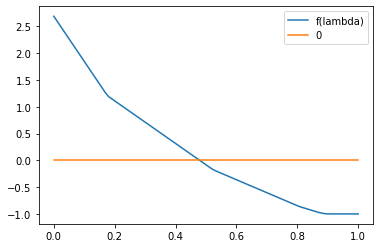

In [15]:
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 101)
plt.plot(x, [eval_expression(el) for el in x], label='f(lambda)')
plt.plot([0, 1], [0, 0], label='0')
plt.legend()

plt.show()


In [16]:
(alpha - lower_bound_lambda) / (alpha_element_squared + sigma_element_squared)

array([[0.88919904],
       [0.59634073],
       [1.        ],
       [0.92938013],
       [0.68342163],
       [0.04856998],
       [0.04856998],
       [0.04856998],
       [0.04856998],
       [0.04856998]])